A variant of the Metropolis-Hastings (MH) algorithm that uses clever proposals and is therefore more efficient (you can get a good approximate of the posterior with far fewer samples) is Gibbs sampling. A problem with MH is the need to choose the proposal distribution, and the fact that the acceptance rate may be low.

The improvement arises from adaptive proposals in which the distribution of proposed parameter values adjusts itself intelligently, **depending upon the parameter values at the moment**. This dependence upon the parameters at that moment is an exploitation of conditional independence properties of a graphical model to automatically create a good proposal, with acceptance probability equal to one.

### Main Idea

Suppose we have a 3-dimensional joint distribution. Estimating this joint distribution is much harder than a 1-dimensional distribution. Subsequently, sampling is also harder in $\mathbb{R}^3$. In Gibbs sampling, you condition each variable on the values of all the other variables in the distribution. For example, if we have $D=3$ variables:

$$x_{1}^{s+1} \sim p(x_1 | x_2^s,x_3^s)$$

$$x_{2}^{s+1} \sim p(x_2 | x_1^{s+1},x_3^s)$$

$$x_{3}^{s+1} \sim p(x_3 | x_1^{s+1},x_2^{s+1})$$

where $x_1, x_2,...,x_n$ are variable $1, 2,...,n$, respectively. By conditioning on the values of the other variables, sampling from the conditional distribution is much easier than the joint. Because of the exploitation of conditional independence properties of graphical models, the Gibbs algorithm can readily generalize to $D$ variables. 

### Gibbs Sampling - Bayesian Gaussian Mixture Model

Here, the Gibbs sampling algorithm is implemented in PyTorch for a 2-dimensional Bayesian Gaussian Mixture Model (GMM). The Bayesian GMM is given by:

$$p(z = k, x | \theta) = \pi_k \mathcal{N}(x|\mu_k, \sum_k)$$

where the parameters $\theta$ are known and implemented using PyTorch's `MixtureSameFamily` distribution class. This class implements a batch of mixture distributions where all components are from different parameterizations of the same distribution type (Normal distributions in this example). It is then parameterized by a `Categorical` distribution over $k$ components. 

For a GMM, the full conditional distributions are:

$$p(x|z = k, \theta) = \mathcal{N}(x|\mu_k, \sum_k)$$

This conditional distribution reads; "the probability of data $x$ given component $k$ parameterized by $\theta$ is distributed according to a Normal distribution with a mean vector $\mu$ and covariance $\sum$ according to component $k$".  

$$p(z = k | x) = \frac{\pi_k \mathcal{N}(x|\mu_k, \sum_k)}{\sum_{k'} \mathcal{N}(x|\mu_{k'}, \sum_{k'})}$$

This conditional distribution is given by Bayes rule and reads; "the probability of component $k$ given we observe some data $x$ is equal to the prior probability $\pi$ of component $k$ times the likelihood of data $x$ being distributed according to a Normal distribution with a mean vector $\mu$ and covariance $\sum$ according to component $k$" over the total probability of components $k$. 

With the conditional distributions defined, the Gibbs sampling algorithm can be implemented. Below is the full code to reproduce the results and each main step is outlined below the code block.

In [1]:
#| echo: false
import numpy as np
import torch
from torch import distributions as dist
import matplotlib.pyplot as plt
import argparse
import warnings
warnings.filterwarnings("ignore")

In [2]:
#| code-fold: true
def plot_gibbs(trace_hist, probs, scales, mus, n_iters, n_eval=500):

    mix = dist.Categorical(probs=probs)
    comp = dist.Independent(dist.Normal(loc=mus, scale=scales), 1)
    norm_mixture = dist.MixtureSameFamily(mix, comp)
    
    x = torch.arange(-1, 2, 0.01)
    y = torch.arange(-1, 2, 0.01) 

    X, Y = torch.meshgrid(x, y)
    Z = torch.dstack((X, Y))
    probs_z = torch.exp(norm_mixture.log_prob(Z))

    fig = plt.figure(figsize=(12, 5))
    plt.contourf(X, Y, probs_z, levels=15)
    plt.scatter(trace_hist[:, 0], trace_hist[:, 1], alpha=0.25, color='red')
    plt.xlim(-1, 2)
    plt.ylim(-1, 2)
    plt.colorbar()
    plt.xlabel(xlabel='$X$')
    plt.ylabel(ylabel='$Y$')
    plt.title('Gibbs Sampling for a Mixture of 2d Gaussians')
    plt.show()

In [3]:
def gibbs_sampler(x0, z0, kv, probs, mu, scale, n_iterations, rng_key=None):
    """
    implements the gibbs sampling algorithm for known params. of
    a 2d GMM
    """

    x_current = x0
    z_current = z0

    x_samples = torch.zeros(n_iterations, 2)
    z_samples = torch.zeros(n_iterations)
     
    for n in range(1, n_iterations):

        # p(Z = k | X = x)
        probs_z = torch.exp(
            dist.Independent(
                dist.Normal(loc=mu, scale=scale), 1).log_prob(x_current))
        # p(Z = k) * p(Z = k | X = x)
        probs_z *= probs
        # denom. of Bayes
        probs_z = probs_z / torch.sum(probs_z)
        # indexing component Z = k
        z_current = kv[-1] if probs_z[-1] > probs[0] else kv[0]
        # draw new sample X conditioned on Z = k
        x_current = dist.Normal(loc=mu[z_current], scale=scale[z_current]).sample()

        x_samples[n] = x_current
        z_samples[n] = z_current

    return x_samples, z_samples

In [4]:
def main(args):

    # initial sample values
    x0 = torch.randn((2,))
    # initial component values
    z0 = torch.randint(0, 2, (2,))
    # for indexing
    kv = np.arange(2)
    # defining prior mixture probability p(Z = k)
    mixture_probs = torch.tensor([0.4, 0.6])
    # defining mu vector and covariance matrix
    mus = torch.randn(2, 2)
    scales = torch.rand(2, 2)

    x_samples, z_samples = gibbs_sampler(
        x0, z0, kv, mixture_probs, mus, scales, args.iters
        )

    plot_gibbs(x_samples, mixture_probs, scales, mus, args.iters)

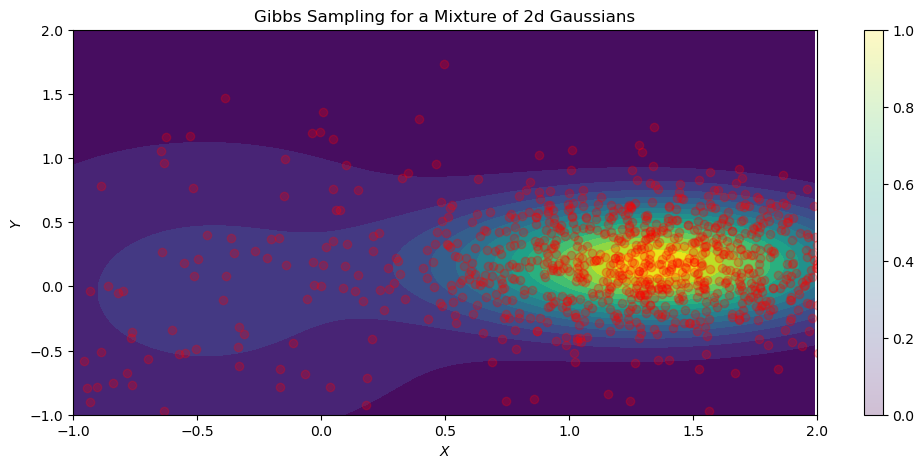

In [5]:
parser = argparse.ArgumentParser(description='rw-mh')
parser.add_argument('--iters', type=int, default=1000)
args = parser.parse_args("")

main(args)

### Explanation of Code

The main steps to implement the Gibbs sampling algorithm:

1.  The `main()` function defines the initial values for the sample, component, and mixture distribution. 

2. The `gibbs_sampler()` function first sets the values of `x_current` and `z_current` for current data point $x$ and component $z$, respectively. To analyze the trace history of the sampler, `x_samples` and `z_samples` are empty lists. 

3. In the for loop, the conditional $p(z = k \vert x)$ is computed using `x_current`, i.e., given we have observed datum $x$, what is the log probability of component $Z = k$. 

4. `probs_z` is then multiplied by the prior probability of the mixture components. 

5. Then, the denominator for the conditional $p(z = k \vert x)$ is computed by dividing `probs_z` by the total probability.

6. Since there are only two components in this GMM, we use logic to determine which component is _most likely_ with the `x_current`. As zero-based indexing is used, the components are $k = 0, 1$. Therefore, if the probability of $k=1 > k=0$, then use index$=1$, else index$=0$. 

7. `z_current` defines the component using zero-based indexing. Thus, indexing `mu` and `scale` by the current, most likely component, new samples are drawn according to the conditional Normal distribution.

8. Data and component samples are appended for analyzing the trace history.

### Limitations

Although Gibbs sampling can generalize to $D$ variables, the algorithm becomes inefficient as it tends to get stuck in small regions of the posterior for, potentially, a long number of iterations. This isn't because of the large number of variables, but rather, because models with many parameters tend to have regions of high correlation in the posterior. High correlation between parameters means a narrow ridge of probability combinations, resulting in the sampler getting "stuck". 